Very similar to the positive test code, except for the fact that here high autocorrelation makes programmes more likely to appear. The expectation is that for this run training will be notably better. The negative test name is because I got confused oops.

  0%|          | 0/800 [00:00<?, ?it/s]C:\Users\plogo\AppData\Local\Temp\ipykernel_26876\194585056.py:122: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_2112s1s0to\croot\pytorch-select_1700158736573\work\torch\csrc\utils\tensor_new.cpp:264.)
  tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
100%|██████████| 800/800 [5:39:59<00:00, 25.50s/it]  


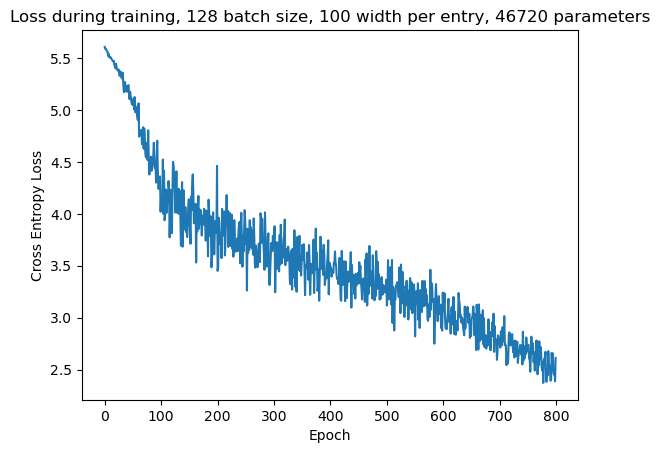

ValueError: cannot reshape array of size 800 into shape (15)

In [6]:
# Importing libraries

!pip install cellpylib

import cellpylib as cpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import seaborn as sns
import time
import math
import matplotlib.cm as cm # For colourmap plots later
from tqdm import tqdm

# Data generation parameters
data_size = 100 # the number of data points in each row of data
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model

# Training parameters
num_epochs = 800  # Number of training epochs
hidden_size = 128  # Update with the desired size of the hidden layer
learning_rate = 0.005 # learning rate used later in the optimizer
batch_size = 128 # Batch size used when creating the train and test datasets. 32 is more suitable for this problem.

# Used in the evaluation of the model
accuracy_frequency = 1

epochs = np.arange(0,num_epochs, 1)

def prog_dist_weight_autocorr(): # NOTE: UNTESTED. Takes the aurocorrelations of programmes, and makes more autocorrelated programmes more commmon (almost like the proper weighting)
    autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16, 100, 100]
    programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
    prog_list = np.zeros(256)
    for index, item in enumerate(programmes):
        autocorrelation = autocorr[index]
        prog_list[item] = (autocorrelation + 1)**(3)
    return prog_list

programmes_prob_distribution = prog_dist_weight_autocorr()

# Model Initialisation / Training setup

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        return out

# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
num_classes = 256 #Number of potential classes, here stuck at 256

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

def reset_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            module.reset_parameters()

# Data generation functions (where the programmes_considered have a probability distribution)

def create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Creating the dataset and labels variables to be populated later
    dataset = np.empty(shape=(number_of_samples, data_size), dtype=int) # each row is data_size length, with number_of_samples rows
    labels = np.empty(shape=(1, number_of_samples), dtype=int)

    # Stating the space of considered programmes
    programmes = np.arange(0,256,1)

    # Normalising the distribution in case it is not already normalised
    programmes_total = sum(programmes_prob_distribution)
    programmes_prob_distribution_norm = [x / programmes_total for x in programmes_prob_distribution]
    
    for i in range(number_of_samples):

        # Randomly selecting a rule number according to the probability distribution given
        rule_number = np.random.choice(a = programmes, size=None, replace=True, p = programmes_prob_distribution_norm)
        #print(f"Considering rule_number = ", rule_number)
        cellular_automaton = cpl.init_random(data_size)
        cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
        #print(cellular_automaton[-1])
        dataset[i] = cellular_automaton[-1]
        labels[:,i] = rule_number

    return [dataset, labels]

def data_loader(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Generate the data according to input parameters
    [dataset, labels] = create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps)
    labels = labels[0] # Deal with the fact that the output is a list of a single list

    # Shifting the labels such that they are indexed from 0. Required for cross entropy to work
    #labels = [x - min(labels) for x in labels] #!!! Not currently shifting labels in a test to alter them later - may help with training in smaller batches
    # Use data_split
    data = [(data_sample, label) for data_sample, label in zip(dataset, labels)]

    train_dataset, train_labels = zip(*data)
    
    tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
    
    train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader

# Evaluates a model over the space of all possible functions. Outputs a vector giving that performance

def model_evaluation(model, data_size, timesteps, batch_size):

    # State which programmes are being considered. In this case, it's all of them.
    #programmes_considered = np.arange(0,256,1) #NOTE: THIS DISABLING IS TEMPORARY. AIM TO REINTRODUCE IT
    programmes_considered = np.array([0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]) # The programmes used at the moment in autocorrelation

    accuracy_vector = np.empty(256)
    
    for programme in programmes_considered:

        programmes_prob_distribution = [0]*256
        programmes_prob_distribution[programme] = 1

        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for data, labels in train_loader:
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            accuracy = 100 * correct / total #returns the accuracy as a percentage
            #print(f"For programme " + str(programme) + ": Accuracy = " + str(accuracy))
        accuracy_vector[programme] = accuracy
                
    return accuracy_vector

# Training loop (includes data generation). Note that here training and test loss cease to make much sense

def main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs):

    # Initisalise training and test loss tracking variables
    training_loss = np.empty(num_epochs)

    # Initialise an array to track not only the general training and test loss, but also the accuracy on individual programme classification during training.
    # This is to attempt to see grokking.
    # Form: Each row of accuracy_array is an epoch, each column of accuracy_array is a binary 1 or 0 based on whether or not it was correctly classified. 
    #accuracy_frequency = 100 # Once every 100 epochs, the accuracy is measured
    accuracy_array = np.empty((math.floor(num_epochs/accuracy_frequency), 256))
    # Initialising variaable for tracking where in the accuracy_array to write data
    eval_count = 0
    # Each epoch here trains over 1 batch size of data (which at the moment is 32). Each epoch is therefore smaller and better controlled.
    for epoch in tqdm(range(num_epochs)):

        # Continually monitoring accuracy of the model by adjusting the accuracy_array
        if epoch%accuracy_frequency==0:
            accuracy_vector = model_evaluation(model, data_size, timesteps, batch_size)
            accuracy_array[eval_count] = accuracy_vector
            eval_count += 1
        
        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)
        for data, labels in train_loader:
            # Forward pass
            outputs = model(data)
    
            #Shifting labels for loss calculation
            shifted_labels = labels - torch.min(labels)
            shifted_labels = shifted_labels.long()
            loss = criterion(outputs, shifted_labels)
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss after each epoch
        #if epoch%10==0:
        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
        training_loss[epoch] = loss.item()

    return [training_loss, accuracy_array]

[training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)

training_loss_copy = np.copy(training_loss)
accuracy_array_copy = np.copy(accuracy_array)

################################ PLOTTING SOFTWARE FROM HERE

parameter_number = sum(p.numel() for p in model.parameters())

plt.plot(epochs, training_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss during training, " + str(batch_size) + " batch size, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
#plt.ylim(bottom = 0)
plt.show()

# Produce Seaborn plots, smoothing out train error. Note that they only work when the number of epochs is divided exactly by the moving_avg

parameter_number = sum(p.numel() for p in model.parameters())

# Taking values from nearby epochs and averaging
moving_avg = 10 # The size of the averaging window being used.
epochs = np.arange(0, num_epochs - num_epochs%moving_avg,1)
#training_loss = training_loss[:-1]
reshaped_training_loss = np.reshape(training_loss, (-1, moving_avg)) #note that if the length of training_loss is not divisible by 10, the final elements are ignored
reshaped_epochs = np.reshape(epochs, (-1, moving_avg))
filtered_epochs = reshaped_epochs[:,0]
repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

pandas_df = pd.DataFrame({'Training Loss': reshaped_training_loss.flatten(), 'Epochs': repeated_filtered_epochs})
pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = ['Training Loss'], var_name='line', value_name = 'Values')


sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title("Loss during training, " + str(batch_size) + " batch size, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
plt.legend(loc='best')
plt.rcParams['figure.dpi'] = 300
plt.show()

# Creating a seaborn plot of the accuracy plots for improved visibility

rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
rel_array = np.array(rel_list)
#lines_plotted = uncorr_array[0:3]
#lines_plotted = rel_array[2: 5]
uncorr_array = rel_array
lines_plotted = rel_array

#rel_programmes = np.asarray(np.where(programmes_prob_distribution != 0))
#uncorr_array = np.array(rel_programmes)
#lines_plotted = uncorr_array[2:5]

#lines_plotted = rel_programmes[0:3]

rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

# Create an axis object for the line plot
fig, ax = plt.subplots()
cmap = cm.get_cmap('rainbow')  # You can choose different colormaps

# Taking values from nearby epochs and averaging
moving_avg = 10 # The size of the averaging window being used.
reshaped_epochs = np.reshape(rel_epochs, (-1, moving_avg))
filtered_epochs = reshaped_epochs[:,0]
repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

for i in tqdm(lines_plotted):
    line = accuracy_array[:,i]
    #color = cmap(lines_plotted[np.where(lines_plotted==i)[0][0]] / (len(lines_plotted) - 1))
    #color = cmap(index / (len(lines_plotted) - 1))
    color = cmap(np.where(lines_plotted == i)[0][0] / (len(lines_plotted) - 1))
    reshaped_line = np.reshape(line, (-1, moving_avg))
    programme_label = 'Programme: ' + str(uncorr_array[np.where(lines_plotted==i)][0])
    pandas_df = pd.DataFrame({programme_label: reshaped_line.flatten(), 'Epochs': repeated_filtered_epochs})
    pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = [programme_label], var_name='line', value_name = 'Values')
    #fig, ax = plt.subplots()
    sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line', ax=ax, palette = [color])

# Create a ScalarMappable object for the colorbar
norm = plt.Normalize(0, len(lines_plotted) - 1)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Set an empty array to associate with the colorbar
cbar = plt.colorbar(sm, ax=ax)

cbar.set_label('Program Number')

num_ticks = len(lines_plotted)  # Number of desired ticks
indices = np.linspace(0, len(lines_plotted) - 1, num_ticks, dtype=int)
tick_positions = indices
tick_labels = lines_plotted[indices]

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

ax.get_legend().remove()

plt.ylabel('Accuracy (%)')

plt.show()

# Plot the programmes probabililty distribution

#programmes_prob_distribution = prog_dist_bell(128, 32)
#programmes_prob_distribution = prog_dist_uncorr()
prog_prob_dist_norm = [x / sum(programmes_prob_distribution) for x in programmes_prob_distribution]
programmes_considered_ = np.arange(0, 256, 1)

plt.plot(programmes_considered_, prog_prob_dist_norm)

plt.xlabel('Programme')
plt.ylabel('Probability')
plt.title('Normalised Probability distribution over programmes')
plt.show()

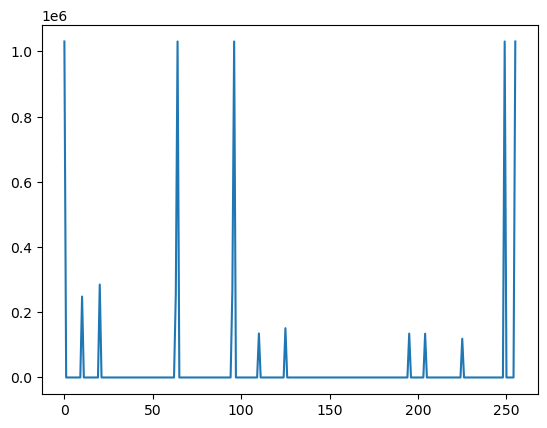

In [4]:
def prog_dist_weight_autocorr(): # NOTE: UNTESTED. Takes the aurocorrelations of programmes, and makes more autocorrelated programmes more commmon (almost like the proper weighting)
    autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16, 100, 100]
    programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
    prog_list = np.zeros(256)
    for index, item in enumerate(programmes):
        autocorrelation = autocorr[index]
        prog_list[item] = (autocorrelation + 1)**(3)
    return prog_list

prog_list = prog_dist_weight_autocorr()

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 256, 1)
plt.plot(x, prog_list)

C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


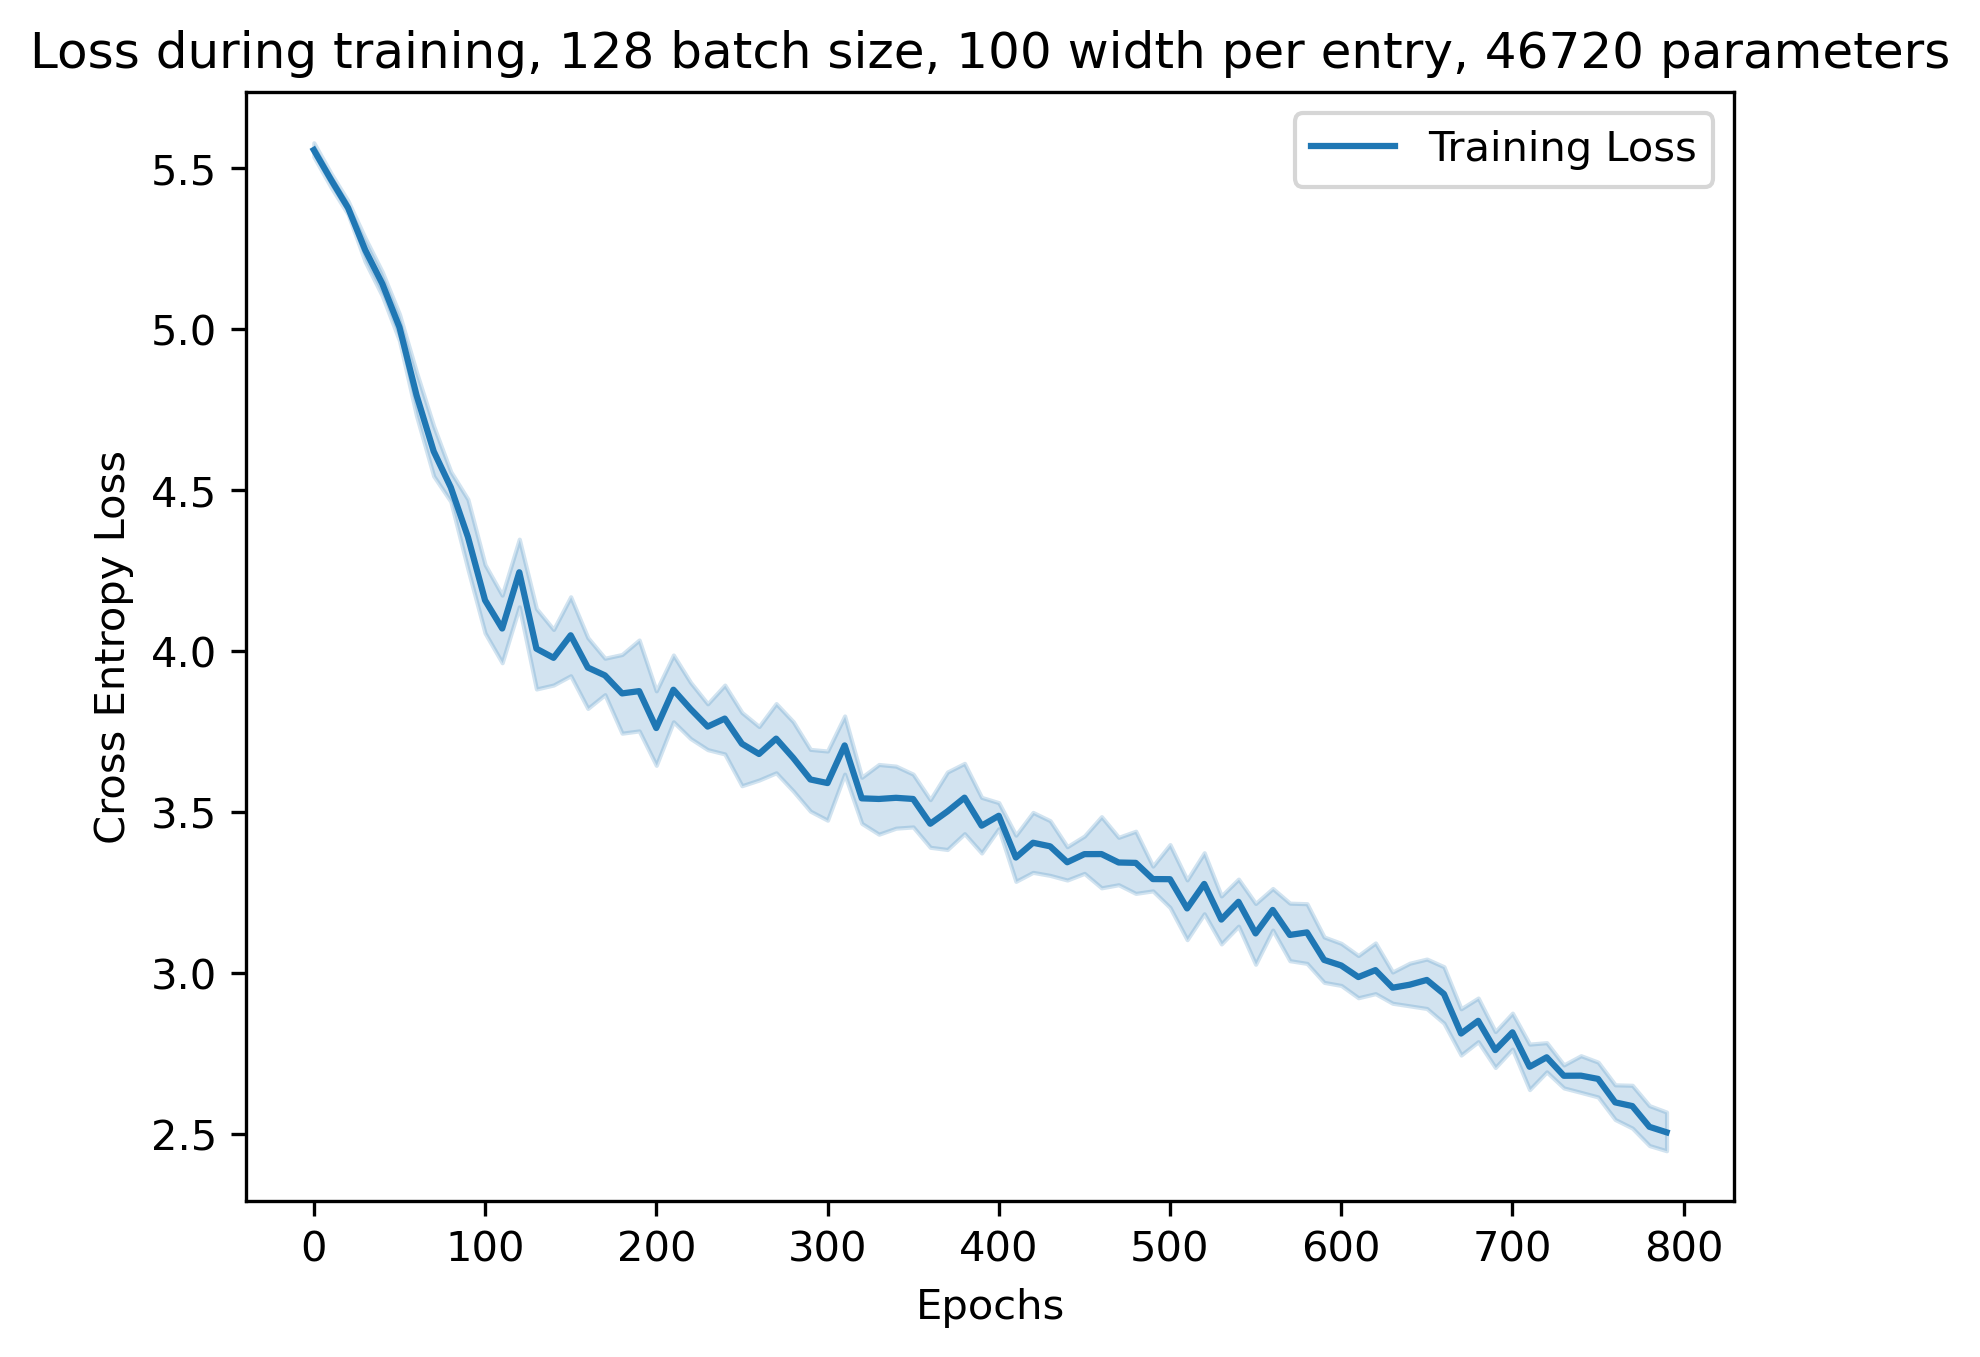

C:\Users\plogo\AppData\Local\Temp\ipykernel_26876\1526596038.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps
  0%|          | 0/14 [00:00<?, ?it/s]C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
  7%|▋         | 1/14 [00:02<00:38,  2.95s/it]C:\Users\

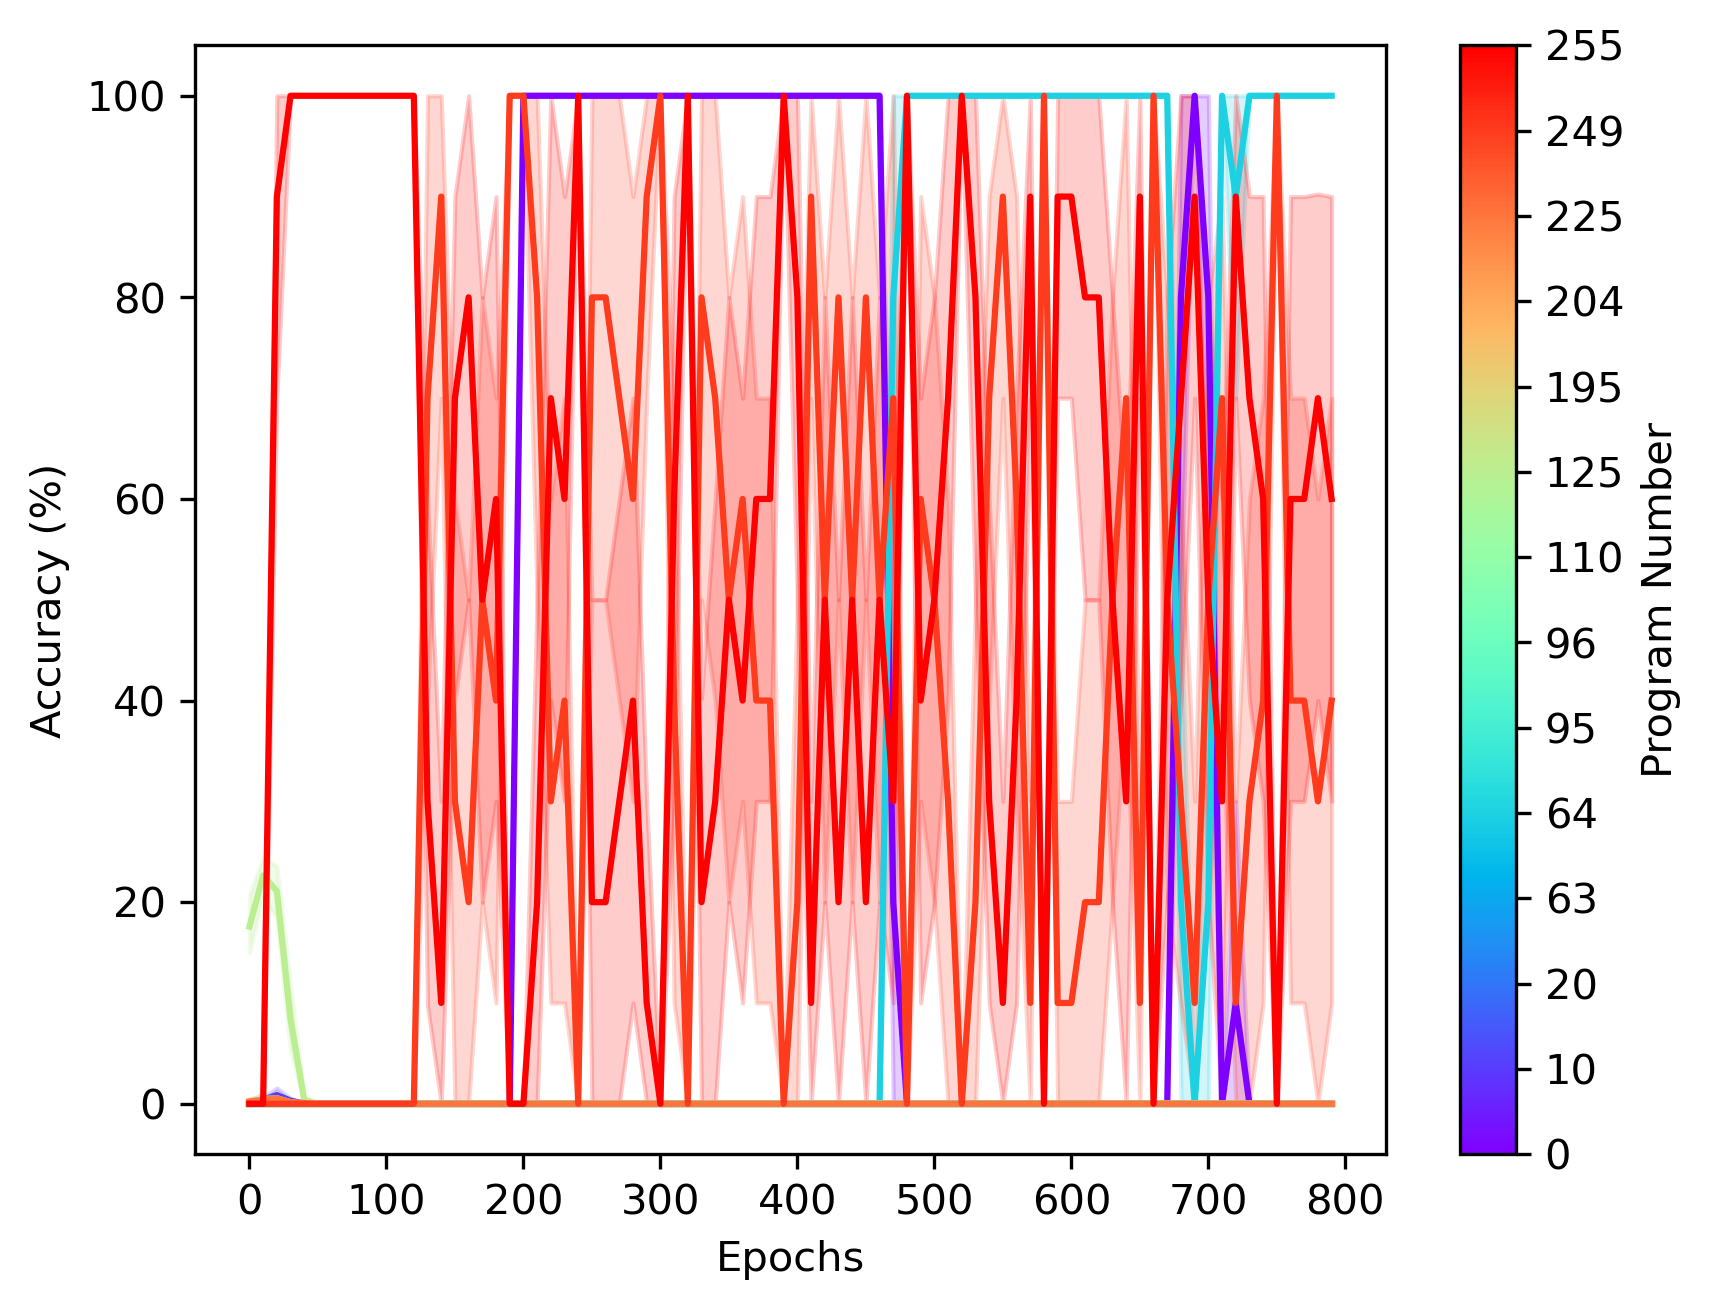

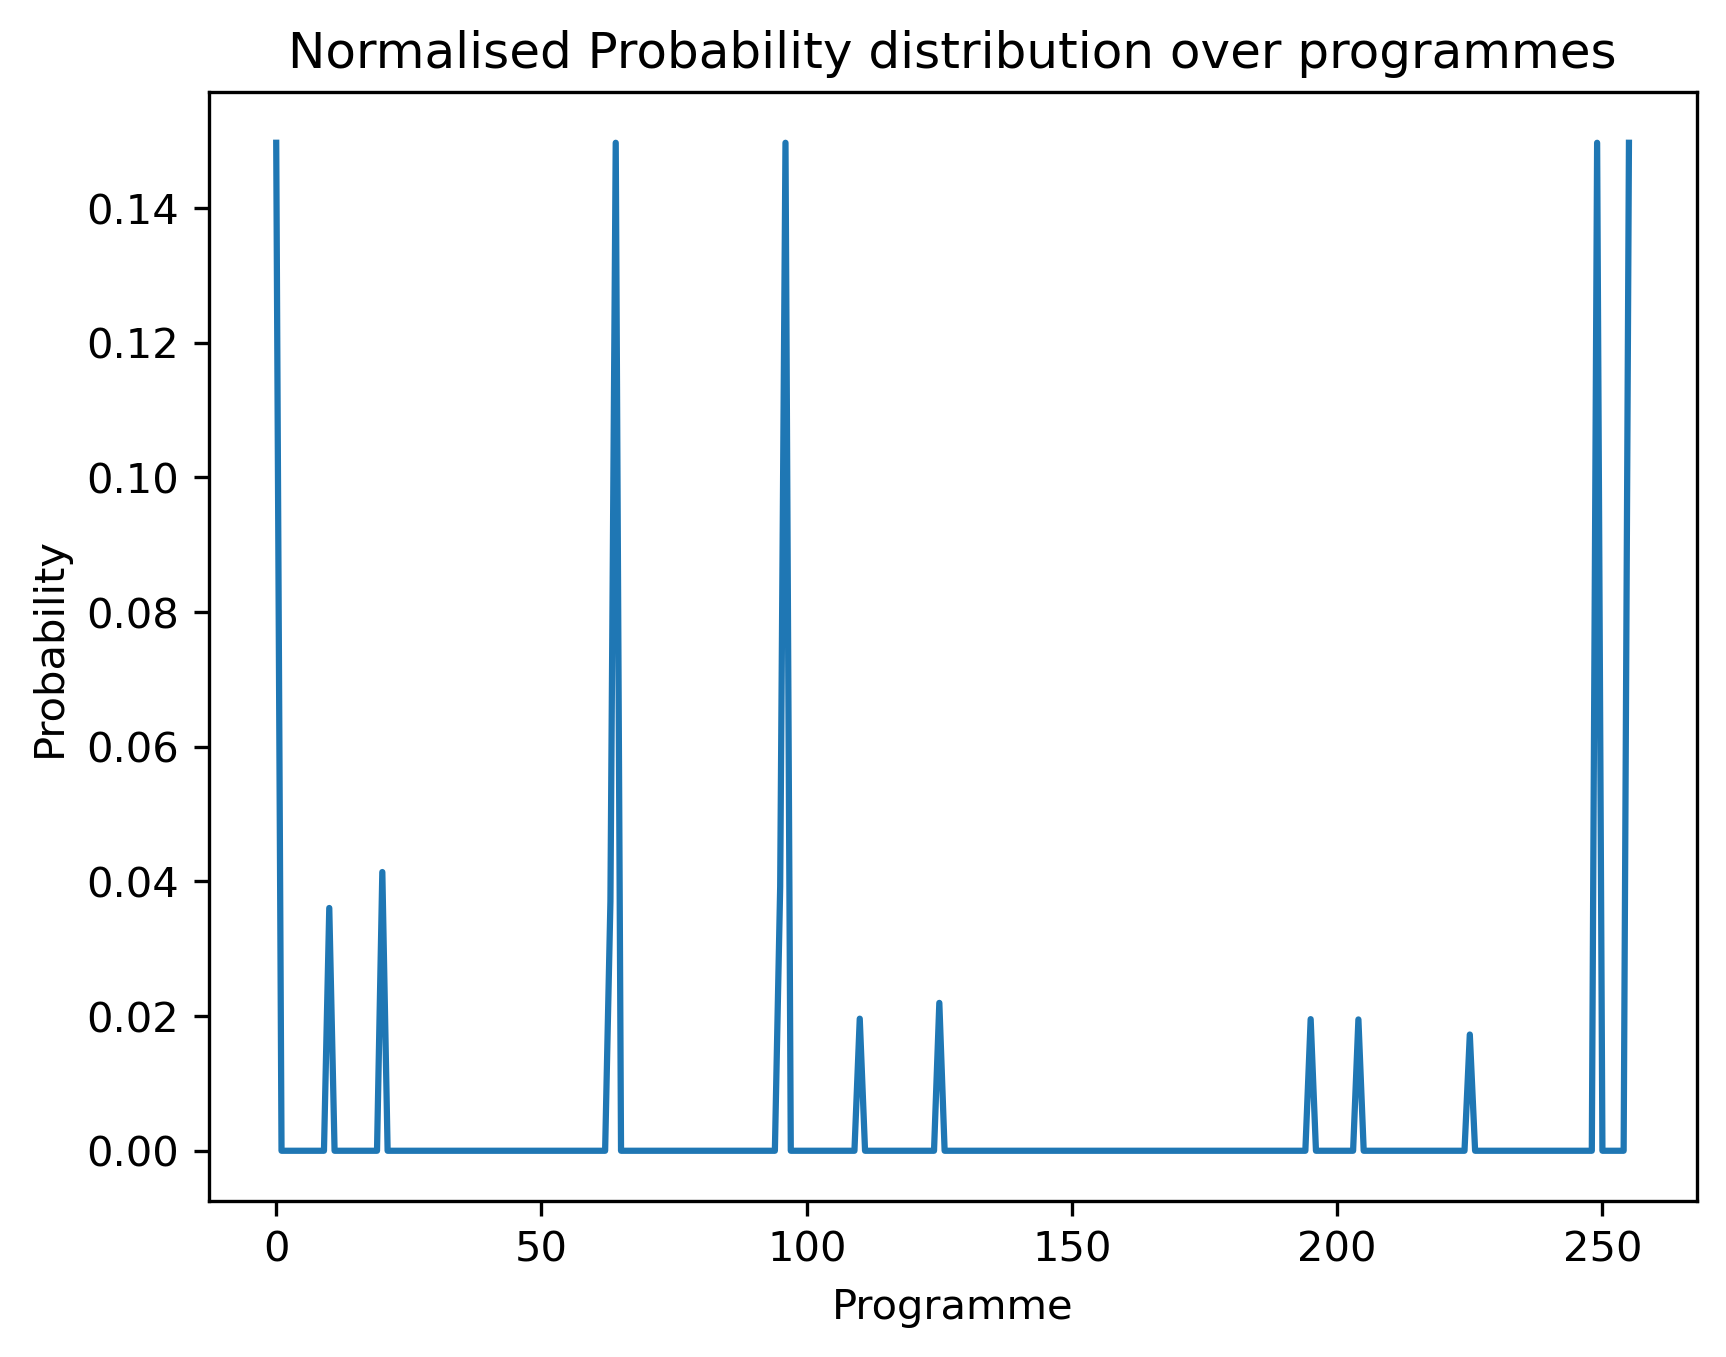

In [8]:
# Importing libraries

# Data generation parameters
data_size = 100 # the number of data points in each row of data
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model

# Training parameters
num_epochs = 800  # Number of training epochs
hidden_size = 128  # Update with the desired size of the hidden layer
learning_rate = 0.005 # learning rate

epochs = np.arange(0, num_epochs, 1)

# Produce Seaborn plots, smoothing out train error. Note that they only work when the number of epochs is divided exactly by the moving_avg

parameter_number = sum(p.numel() for p in model.parameters())

# Taking values from nearby epochs and averaging
moving_avg = 10 # The size of the averaging window being used.
epochs = np.arange(0, num_epochs - num_epochs%moving_avg,1)
#training_loss = training_loss[:-1]
reshaped_training_loss = np.reshape(training_loss, (-1, moving_avg)) #note that if the length of training_loss is not divisible by 10, the final elements are ignored
reshaped_epochs = np.reshape(epochs, (-1, moving_avg))
filtered_epochs = reshaped_epochs[:,0]
repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

pandas_df = pd.DataFrame({'Training Loss': reshaped_training_loss.flatten(), 'Epochs': repeated_filtered_epochs})
pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = ['Training Loss'], var_name='line', value_name = 'Values')


sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title("Loss during training, " + str(batch_size) + " batch size, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
plt.legend(loc='best')
plt.rcParams['figure.dpi'] = 300
plt.show()

# Creating a seaborn plot of the accuracy plots for improved visibility

rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
rel_array = np.array(rel_list)
#lines_plotted = uncorr_array[0:3]
#lines_plotted = rel_array[2: 5]
uncorr_array = rel_array
lines_plotted = rel_array

#rel_programmes = np.asarray(np.where(programmes_prob_distribution != 0))
#uncorr_array = np.array(rel_programmes)
#lines_plotted = uncorr_array[2:5]

#lines_plotted = rel_programmes[0:3]

rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

# Create an axis object for the line plot
fig, ax = plt.subplots()
cmap = cm.get_cmap('rainbow')  # You can choose different colormaps

# Taking values from nearby epochs and averaging
moving_avg = 10 # The size of the averaging window being used.
reshaped_epochs = np.reshape(rel_epochs, (-1, moving_avg))
filtered_epochs = reshaped_epochs[:,0]
repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

for i in tqdm(lines_plotted):
    line = accuracy_array[:,i]
    #color = cmap(lines_plotted[np.where(lines_plotted==i)[0][0]] / (len(lines_plotted) - 1))
    #color = cmap(index / (len(lines_plotted) - 1))
    color = cmap(np.where(lines_plotted == i)[0][0] / (len(lines_plotted) - 1))
    reshaped_line = np.reshape(line, (-1, moving_avg))
    programme_label = 'Programme: ' + str(uncorr_array[np.where(lines_plotted==i)][0])
    pandas_df = pd.DataFrame({programme_label: reshaped_line.flatten(), 'Epochs': repeated_filtered_epochs})
    pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = [programme_label], var_name='line', value_name = 'Values')
    #fig, ax = plt.subplots()
    sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line', ax=ax, palette = [color])

# Create a ScalarMappable object for the colorbar
norm = plt.Normalize(0, len(lines_plotted) - 1)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Set an empty array to associate with the colorbar
cbar = plt.colorbar(sm, ax=ax)

cbar.set_label('Program Number')

num_ticks = len(lines_plotted)  # Number of desired ticks
indices = np.linspace(0, len(lines_plotted) - 1, num_ticks, dtype=int)
tick_positions = indices
tick_labels = lines_plotted[indices]

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

ax.get_legend().remove()

plt.ylabel('Accuracy (%)')

plt.show()

# Plot the programmes probabililty distribution

#programmes_prob_distribution = prog_dist_bell(128, 32)
#programmes_prob_distribution = prog_dist_uncorr()
prog_prob_dist_norm = [x / sum(programmes_prob_distribution) for x in programmes_prob_distribution]
programmes_considered_ = np.arange(0, 256, 1)

plt.plot(programmes_considered_, prog_prob_dist_norm)

plt.xlabel('Programme')
plt.ylabel('Probability')
plt.title('Normalised Probability distribution over programmes')
plt.show()